In [119]:
# load packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy as sp

# models

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# helpers

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#### Load data

In [120]:
raw_data = pd.read_csv('train.csv')
val_data = pd.read_csv('test.csv')

print(raw_data.shape)
print(val_data.shape)

# check the data

print(raw_data.head(10))

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl

In [121]:
# check NAs

nasdata = raw_data.isna().sum()
nasval = val_data.isna().sum()

#### Data vizualization

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

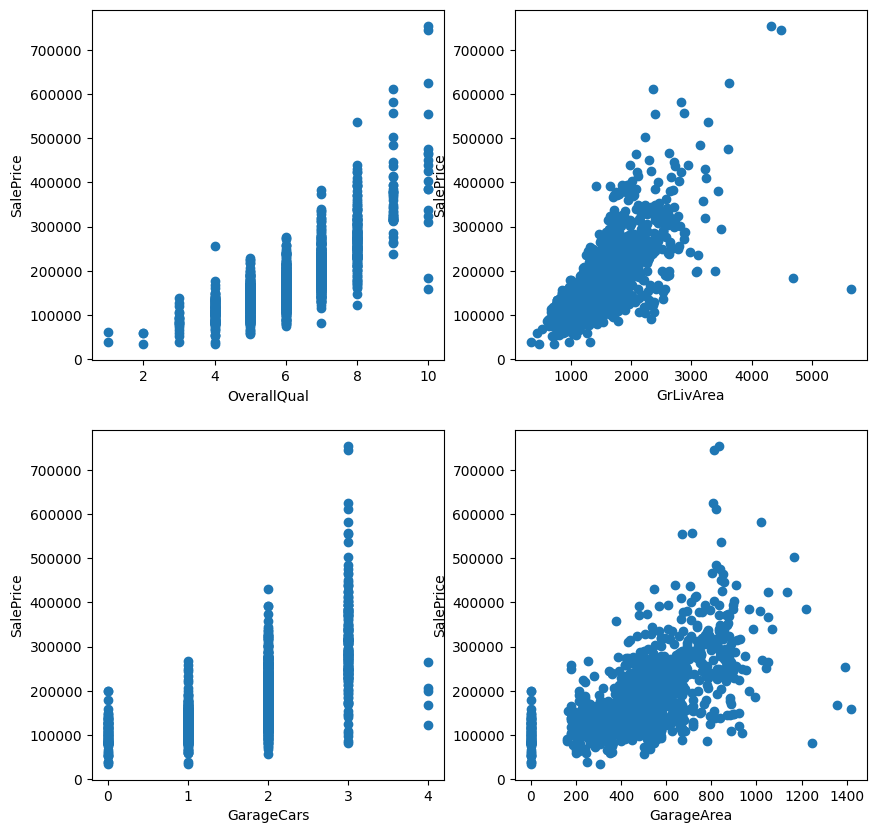

In [122]:
# correlation between sale price and the other numeric  variables

numeric_data = raw_data.select_dtypes(include=[np.number])
corr = numeric_data.corr()
print(corr['SalePrice'].sort_values(ascending=False))

# scatter plots of the most correlated variables in a subplot

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(raw_data['OverallQual'], raw_data['SalePrice'])
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.subplot(2, 2, 2)
plt.scatter(raw_data['GrLivArea'], raw_data['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.subplot(2, 2, 3)
plt.scatter(raw_data['GarageCars'], raw_data['SalePrice'])
plt.xlabel('GarageCars')
plt.ylabel('SalePrice')
plt.subplot(2, 2, 4)
plt.scatter(raw_data['GarageArea'], raw_data['SalePrice'])
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.show()



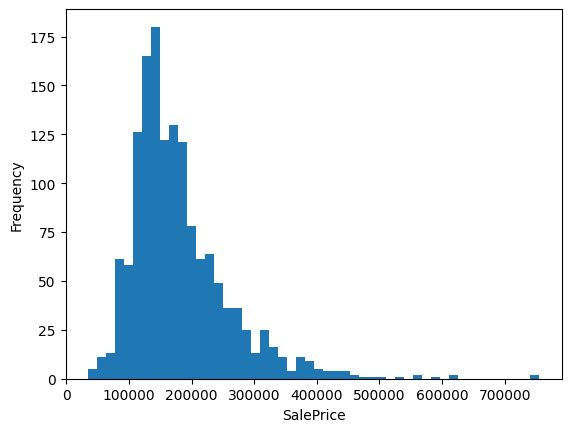

In [123]:
# histogram of sale price

plt.hist(raw_data['SalePrice'], bins=50)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

In [124]:
# deep copy

data = raw_data.copy()
val = val_data.copy()

cleaner = [data, val]

# deep copy2 (without NAs)

data2 = raw_data.copy()
val2 = val_data.copy()

cleaner2 = [data2, val2]


In [125]:
from sklearn.impute import SimpleImputer
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

# numerical cols

num_colsdata = data.select_dtypes(include=[np.number]).columns
num_colsval = val.select_dtypes(include=[np.number]).columns

# categorical cols

cat_cols = data.select_dtypes(include=[object]).columns

data2[num_colsdata] = imputer_num.fit_transform(data2[num_colsdata])
data2[cat_cols] = imputer_cat.fit_transform(data2[cat_cols])
val2[num_colsval] = imputer_num.fit_transform(val2[num_colsval])
val2[cat_cols] = imputer_cat.fit_transform(val2[cat_cols])

In [126]:
# check NAs 

nasdata2 = data2.isna().sum()
nasval2 = val2.isna().sum()


#### Feature engineering

In [127]:
# convert some numeric variables to categorical such sa MSSubClass, MoSold, OverallQual, OverallCond

for dataset in cleaner2:
    dataset['MSSubClass'] = dataset['MSSubClass'].astype(str)
    dataset['MoSold'] = dataset['MoSold'].astype(str)
    dataset['OverallQual'] = dataset['OverallQual'].astype(str)
    dataset['OverallCond'] = dataset['OverallCond'].astype(str)

print(data2.shape)
print(val2.shape)

(1460, 81)
(1459, 80)


Take the log of the SalePrice, since the evaluation metric is based on the log

In [128]:
data2['SalePrice'] = np.log1p(data2['SalePrice'])

y = data2['SalePrice'].copy()

# drop the target variable and id

data2.drop(['SalePrice', 'Id'], axis=1, inplace=True)
val2.drop(['Id'], axis=1, inplace=True)

In [129]:
print(data2.shape)
print(val2.shape)
print(y.shape)

(1460, 79)
(1459, 79)
(1460,)


In [92]:
#check the data

data2.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60.0,RL,65.000000,8450.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2008.0,WD,Normal
1,20.0,RL,80.000000,9600.0,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0.0,0.0,Gd,MnPrv,Shed,0.0,5.0,2007.0,WD,Normal
2,60.0,RL,68.000000,11250.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,0.0,9.0,2008.0,WD,Normal
3,70.0,RL,60.000000,9550.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2006.0,WD,Abnorml
4,60.0,RL,84.000000,14260.0,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0.0,0.0,Gd,MnPrv,Shed,0.0,12.0,2008.0,WD,Normal
5,50.0,RL,85.000000,14115.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,700.0,10.0,2009.0,WD,Normal
6,20.0,RL,75.000000,10084.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,0.0,8.0,2007.0,WD,Normal
7,60.0,RL,70.049958,10382.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0.0,0.0,Gd,MnPrv,Shed,350.0,11.0,2009.0,WD,Normal
8,50.0,RM,51.000000,6120.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,0.0,4.0,2008.0,WD,Abnorml
9,190.0,RL,50.000000,7420.0,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0.0,0.0,Gd,MnPrv,Shed,0.0,1.0,2008.0,WD,Normal


One hot enconding to deal with categorical variables

In [130]:
alldata = pd.concat([data2, val2], axis=0)
categorical_cols = alldata.select_dtypes(include=[object]).columns
alldata = pd.get_dummies(alldata, columns=categorical_cols)

data2 = alldata[:len(data2)]
val2 = alldata[len(data2):]

print(data2.shape)
print(val2.shape)

(1460, 330)
(1459, 330)


#### Modelling

In [131]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data2, y, test_size=0.2, random_state=42)

In [132]:
# test several models in default settings

MLA = [
    #LinearRegression(), linear regression is bugging for some reaso
    Lasso(),
    Ridge(),
    ElasticNetCV(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR()
]

In [133]:
print(y.shape)
print(data2.shape)

(1460,)
(1460, 330)


In [135]:
# use cv split for this

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0) # run model 10x with 60/30 split intentionally leaving out 10%

# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)


# index through MLA and save performance to table
row_index = 0
for alg in MLA:

    # name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    # score with cv
    cv_results = model_selection.cross_validate(alg, data2, y, cv = cv_split, return_train_score = True)
    MLA_compare.loc[row_index, 'MLA RMSE'] = np.sqrt(-model_selection.cross_val_score(alg, data2, y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 # statistically captures 99.7% of the subsets (the worst case scenario)
    # "The Empirical Rule states that 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean."


    # save preds

    alg.fit(data2, y)

    row_index += 1

# print and sort table
    
MLA_compare.sort_values(by = ['MLA RMSE'], ascending = True, inplace = True) # show highest accuracy first
MLA_compare


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,MLA RMSE
4,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.966677,0.885803,0.02197,0.909277,0.137454
3,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.979613,0.860593,0.039505,3.639143,0.151940
1,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.950512,0.836631,0.11947,0.027053,0.163663
5,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.740726,0.727882,0.057926,0.08436,0.212111
2,ElasticNetCV,"{'alphas': None, 'copy_X': True, 'cv': None, '...",0.773799,0.724597,0.21869,0.276018,0.213537
0,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.775116,0.724597,0.217181,0.049276,0.213592


Tuning Lasso

In [136]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'tol': [0.0001, 0.001, 0.01],  # Tolerance for optimization
    'max_iter': [1000, 2000, 3000]  # Maximum number of iterations
}

lasso = Lasso(fit_intercept=True)

grid_search = model_selection.GridSearchCV(lasso, param_grid, cv=cv_split, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(data2, y)

# get best score and best parameters

print(grid_search.best_score_)
print(grid_search.best_params_)


-0.024971779598196107
{'alpha': 0.001, 'max_iter': 1000, 'tol': 0.0001}


In [137]:
bestlasso = Lasso(alpha=0.001, tol=0.0001, max_iter=1000, fit_intercept=True)
bestlasso.fit(X_train, y_train)

# score with RMSE

y_pred = bestlasso.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = bestlasso.score(X_test, y_test)
print("RMSE: ", rmse)
print("Accuracy: ", acc)

RMSE:  0.14409644055525098
Accuracy:  0.8887322534557676


In [147]:
# predict with best lasso 

y_val = bestlasso.predict(val2)
print(y_val)

# convert to original scale

y_val = np.expm1(y_val)
#print(y_val)

# create submission

submission = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': y_val})
print(submission.head(10))

submission.to_csv('submission.csv', index=False) # got a RMSE of 0.14662 on kaggle


[11.68471171 11.85919288 12.09676698 ... 11.97298894 11.72892903
 12.33997568]
     Id      SalePrice
0  1461  118741.398680
1  1462  141377.062834
2  1463  179290.271217
3  1464  196996.467354
4  1465  189544.452030
5  1466  172777.723297
6  1467  188538.475700
7  1468  164973.712042
8  1469  191408.106192
9  1470  124893.942203


Tuning GradientBoostingRegressor

In [142]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'max_depth': [2, 3, 4, 5],  # Maximum depth of the individual estimators
    'min_samples_split': [2, 3, 4],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3],  # Minimum number of samples required to be at a leaf node
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the individual base learners
}

gbr = GradientBoostingRegressor()

grid_search = model_selection.GridSearchCV(gbr, param_grid, cv=cv_split, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(data2, y)

# get best score and best parameters

print(grid_search.best_score_)
print(grid_search.best_params_) 

# predict with best gbr


-0.017503564436788365
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 0.9}


In [143]:
# best gbr

bestgbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=3, subsample=0.9)
bestgbr.fit(X_train, y_train)

# score with RMSE

y_pred = bestgbr.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = bestgbr.score(X_test, y_test)
print("RMSE: ", rmse)
print("Accuracy: ", acc)

RMSE:  0.14016409427896248
Accuracy:  0.8947223125841334


In [150]:
# predict with best gbr

y_valgbr = bestgbr.predict(val2)
print(y_valgbr)

# convert to original scale

y_valgbr = np.expm1(y_valgbr)
print(y_valgbr)

# create submission

submission2 = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': y_valgbr})
print(submission2.head(10))

submission2.to_csv('submission2.csv', index=False) # got a RMSE of 0.14052 on kaggle (improved!)


[11.72072962 11.93357741 12.139628   ... 11.96522553 11.76016683
 12.22628591]
[123096.20628331 152294.41151454 187141.94276192 ... 157191.35572434
 128047.81449612 204082.78759663]
     Id      SalePrice
0  1461  123096.206283
1  1462  152294.411515
2  1463  187141.942762
3  1464  180693.599612
4  1465  197742.148394
5  1466  177269.510311
6  1467  179773.681689
7  1468  170462.197653
8  1469  175800.985035
9  1470  126710.935820
